<a href="https://colab.research.google.com/github/Abhinash200301/DELINEATION-OF-SMALL-WATER-BODIES-USING-SENTINEL-2-DATA/blob/main/U_Net%2B%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

abhinashanilkumar_dataset_bhapur_path = kagglehub.dataset_download('abhinashanilkumar/dataset-bhapur')

print('Data source import complete.')


In [ ]:
# !pip install geotile

In [ ]:
# from geotile import GeoTile

In [ ]:
# PATH_TRAIN_X = r'/content/drive/MyDrive/nayagarh_data/train_x.tif'
# PATH_TRAIN_Y = r'/content/drive/MyDrive/nayagarh_data/Train x vector'

In [ ]:
# gt_train = GeoTile(PATH_TRAIN_X)
# gt_train.meta

In [ ]:
#gt_train.generate_tiles(r'/content/drive/MyDrive/nayagarh_data/train_x_tiles', prefix='train_')

In [ ]:
# gt_train.rasterization(PATH_TRAIN_Y, '/content/drive/MyDrive/nayagarh_data/y_train.tif')

In [ ]:
# gt_train_y = GeoTile('/content/drive/MyDrive/nayagarh_data/y_train.tif')
# gt_train_y.generate_tiles(r'/content/drive/MyDrive/nayagarh_data/train_y_tiles', prefix='train_')

In [ ]:
# # generate tiles and store it inside geotile package
# gt_train.generate_tiles(save_tiles=False)
# gt_train_y.generate_tiles(save_tiles=False)

# # preprocessing (eg. convert nan to zero and normalization of tiles)
# gt_train.convert_nan_to_zero()
# # gt_train.normalize_tiles()

In [ ]:
# gt_train.normalize_tiles()

In [ ]:
# import numpy as np
# gt_train.tile_data.min(), gt_train.tile_data.max()

In [ ]:
# # save it as a numpy array
# gt_train.save_numpy('/content/drive/MyDrive/nayagarh_data/train_x.npy')
# gt_train_y.save_numpy('/content/drive/MyDrive/y_train.npy')

In [ ]:
# X_train = np.load('/content/drive/MyDrive/nayagarh_data/train_x.npy')
# X_train.max(), X_train.min(), X_train.dtype, X_train.shape

In [ ]:
# y_train= np.load('/content/drive/MyDrive/y_train.npy')

In [ ]:
# import matplotlib.pyplot as plt

# # Let's plot a sample input RGB image and output image with buildings
# fig, (ax1, ax2) = plt.subplots(1,2)
# img = np.random.randint(0, X_train.shape[0])
# print(img)
# ax1.imshow(X_train[img, :, :, :3])
# ax2.imshow(y_train[img, :, :, 0])
# ax1.set_title("Image")
# ax2.set_title('Mask')
# plt.show()

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!pip install tensorflow

In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow.keras.layers as L
from PIL import Image

from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout

2025-01-01 15:48:30.384773: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-01 15:48:30.384866: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-01 15:48:30.388693: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# import os
# os.chdir(r'/content/drive/MyDrive/Bhapur_data')

In [ ]:
train_xx_initial = np.load('/kaggle/input/dataset-bhapur/train_x (1).npy')
train_yy_initial = np.load('/kaggle/input/dataset-bhapur/y_train (1).npy')

print(train_xx_initial.shape, train_yy_initial.shape)
train_xx_initial.max(), train_xx_initial.min()

(270, 256, 256, 4) (270, 256, 256, 1)


(1.0, 0.0)

In [ ]:
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
import numpy as np

# Define augmentation pipeline
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontal flip
    iaa.Flipud(0.5),  # Vertical flip
    iaa.Affine(rotate=(-45, 45)),  # Random rotation between -45 and 45 degrees
    iaa.Affine(scale=(0.5, 1.5)),  # Random scaling between 0.5x and 1.5x
    iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),  # Random translation
    # iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  # Gaussian noise
    # iaa.ElasticTransformation(alpha=50, sigma=5)  # Elastic deformation
])

In [ ]:
augmented_images = []
augmented_masks = []

num_augmentations = 3
# Apply augmentation to each original image and mask
for i in range(train_xx_initial.shape[0]):
    image = train_xx_initial[i]
    mask = train_yy_initial[i]

    # Create a segmentation map object from the mask
    segmentation_map = SegmentationMapsOnImage(mask, shape=image.shape)

    # Apply augmentation num_augmentations times
    for _ in range(num_augmentations):
        # Apply the same augmentation to both image and mask
        augmented_image, augmented_segmentation_mask = seq.augment(image=image, segmentation_maps=segmentation_map)

        # Append the augmented image and mask to the lists
        augmented_images.append(augmented_image)
        augmented_masks.append(augmented_segmentation_mask.get_arr())

# Convert lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)

# append augmented images/masks with original images/masks
train_xx = np.concatenate((train_xx_initial, augmented_images), axis=0)
train_yy = np.concatenate((train_yy_initial, augmented_masks), axis=0)

In [ ]:
# append augmented images/masks with original images/masks
train_xx = np.concatenate((train_xx_initial, augmented_images), axis=0)
train_yy = np.concatenate((train_yy_initial, augmented_masks), axis=0)

In [ ]:
# release memory
del augmented_images
del augmented_masks

In [ ]:
train_xx.max(), train_xx.min(), train_xx.dtype

(1.0, 0.0, dtype('float32'))

In [ ]:
train_xx.shape, train_yy.shape

((1080, 256, 256, 4), (1080, 256, 256, 1))

In [ ]:
num_samples = train_xx.shape[0]
shuffled_indices = np.random.permutation(num_samples)

train_xx = train_xx[shuffled_indices]
train_yy = train_yy[shuffled_indices]

1063


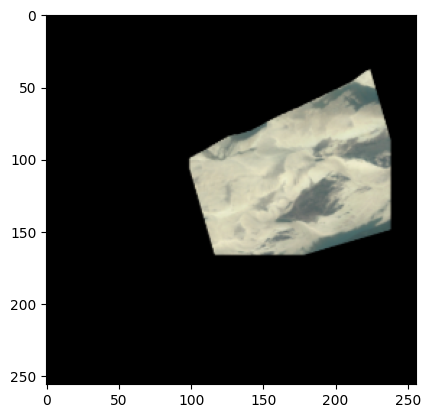

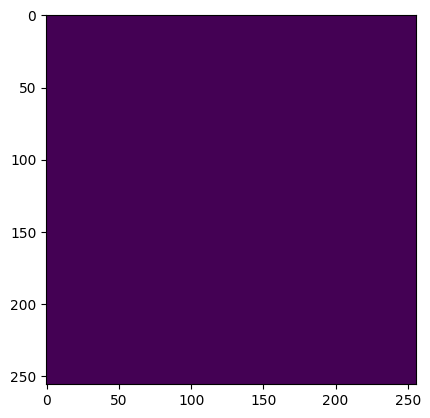

In [ ]:
# Let's plot a sample input RGB image and output image with buildings
img = np.random.randint(0, train_xx.shape[0])
print(img)
plt.imshow(train_xx[img, :, :, :3])
plt.show()
plt.imshow(train_yy[img, :, :, 0])
plt.show()

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, concatenate, Conv2DTranspose
from tensorflow.keras.models import Model

In [ ]:
def nested_unet(input_shape=(256, 256, 4), num_classes=1):
    # Input
    inputs = Input(input_shape)

    # Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottom Level
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Expansive Path
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(drop5)
    merge6 = concatenate([up6, conv4], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([up7, conv3], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([up8, conv2], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([up9, conv1], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    # Nested Path
    conv4n = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv4n = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4n)
    drop4n = Dropout(0.5)(conv4n)
    pool4n = MaxPooling2D(pool_size=(2, 2))(drop4n)

    conv5n = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4n)
    conv5n = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5n)
    drop5n = Dropout(0.5)(conv5n)

    up6n = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(drop5n)
    merge6n = concatenate([up6n, conv4n], axis=3)
    conv6n = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6n)
    conv6n = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6n)

    up7n = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6n)
    merge7n = concatenate([up7n, conv3], axis=3)
    conv7n = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7n)
    conv7n = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7n)

    up8n = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7n)
    merge8n = concatenate([up8n, conv2], axis=3)
    conv8n = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8n)
    conv8n = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8n)

    up9n = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8n)
    merge9n = concatenate([up9n, conv1], axis=3)
    conv9n = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9n)
    conv9n = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9n)

    # Output
    outputs = Conv2D(num_classes, 1, activation='sigmoid')(conv9n)

    # Model
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
# Compile the model
model = nested_unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 4)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         2368      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 tf.compat.v1.nn.max_pool (  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 TFOpLambda)                                                                                  

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_xx, val_xx, train_yy, val_yy = train_test_split(train_xx, train_yy, test_size=0.2, random_state=42)

In [ ]:
train_xx, test_xx, train_yy, test_yy = train_test_split(train_xx, train_yy, test_size=0.25, random_state=42)

In [ ]:
train_xx.shape, val_xx.shape, test_xx.shape

((648, 256, 256, 4), (216, 256, 256, 4), (216, 256, 256, 4))

In [ ]:
# callback function to stop overfitting the model
checkpointer = tf.keras.callbacks.ModelCheckpoint("best_weight.h5", monitor="val_loss", verbose=1, save_best_only=True, mode="min")
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

callbacks = [
    earlyStopping,
    checkpointer
    ]
history = model.fit(train_xx, train_yy,
                    validation_data=(val_xx, val_yy),
                    epochs=10,
                    batch_size=16,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/10
41/41 [==============================] - ETA: 0s - loss: 1.7223 - accuracy: 0.9806 
Epoch 1: val_loss improved from inf to 0.05619, saving model to best_weight.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 2505s 61s/step - loss: 1.7223 - accuracy: 0.9806 - val_loss: 0.0562 - val_accuracy: 0.9961
Epoch 2/10
41/41 [==============================] - ETA: 0s - loss: 0.0272 - accuracy: 0.9956 
Epoch 2: val_loss improved from 0.05619 to 0.01906, saving model to best_weight.h5
41/41 [==============================] - 2505s 61s/step - loss: 0.0272 - accuracy: 0.9956 - val_loss: 0.0191 - val_accuracy: 0.9961
Epoch 3/10
41/41 [==============================] - ETA: 0s - loss: 0.0184 - accuracy: 0.9957 
Epoch 3: val_loss improved from 0.01906 to 0.01260, saving model to best_weight.h5
41/41 [==============================] - 2507s 61s/step - loss: 0.0184 - accuracy: 0.9957 - val_loss: 0.0126 - val_accuracy: 0.9967
Epoch 4/10
41/41 [==============================] - ETA: 0s - loss: 0.0153 - accuracy: 0.9961 
Epoch 4: val_loss improved from 0.01260 to 0.01254, saving model to best_weight.h5
41/41 [==============================] - 2518s 61s/step - loss: 0.0153

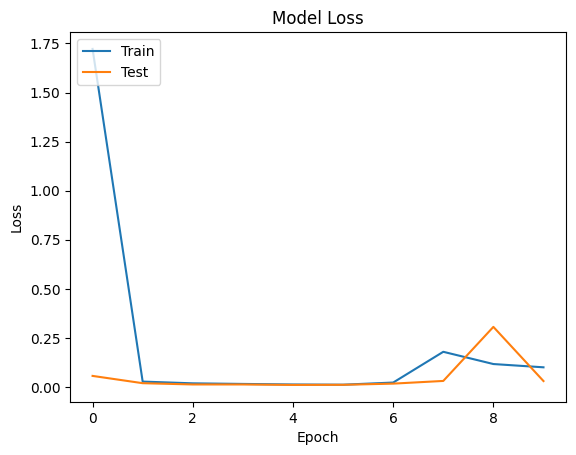

In [ ]:
# plot model loss over training and validation data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('best_weight.h5')

7/7 [==============================] - 217s 31s/step
(216, 256, 256, 1)


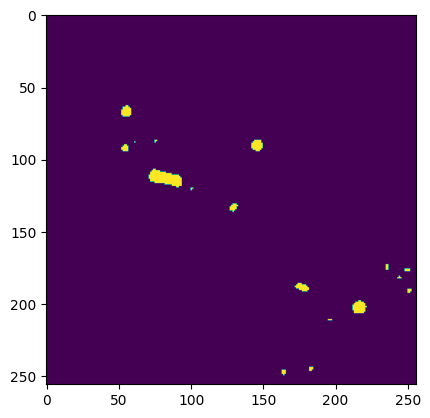

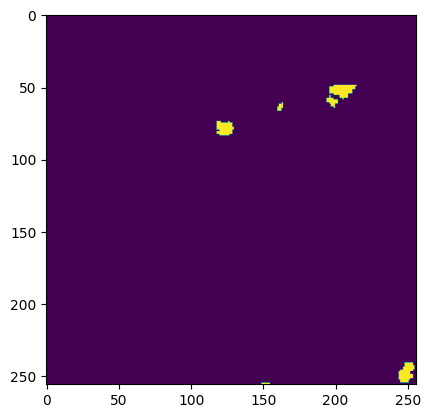

In [ ]:
threshold = 0.2

# prediction of the output
pred_test = model.predict(test_xx)
pred_test = (pred_test > threshold).astype(np.uint8)
print(pred_test.shape)

#let's comare random predicted and actial y values
img = np.random.randint(0, 216)
plt.imshow(pred_test[img, :, :, 0])
plt.show()
plt.imshow(train_yy[img,:,:,0])
plt.show()

In [ ]:
def calculate_metrics(ground_truth, predicted_mask):
    # Flatten the binary masks to 1D arrays
    ground_truth = ground_truth.ravel()
    predicted_mask = predicted_mask.ravel()

    # True Positives, False Positives, False Negatives
    TP = np.sum((ground_truth == 1) & (predicted_mask == 1))
    FP = np.sum((ground_truth == 0) & (predicted_mask == 1))
    FN = np.sum((ground_truth == 1) & (predicted_mask == 0))

    # True Negatives (optional, may not be needed for all cases)
    TN = np.sum((ground_truth == 0) & (predicted_mask == 0))

    # Calculate Precision, Recall, and F1 Score
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy =(TP + TN) / (TP + TN + FN + FP)

    # Calculate Intersection over Union (IoU)
    iou = TP / (TP + FP + FN)

    return precision, recall, f1_score, accuracy, iou

In [ ]:
print(calculate_metrics(train_yy, pred_test))

ValueError: operands could not be broadcast together with shapes (42467328,) (14155776,) 